## Project Graham
 
 [Give an explanation]

In [ ]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import snntorch as snn

from torch.utils.data import DataLoader, TensorDataset

### Electrophysiology / Data Structure Background

Data has already been curated through kilosort, which the model will train on to limit complexity.


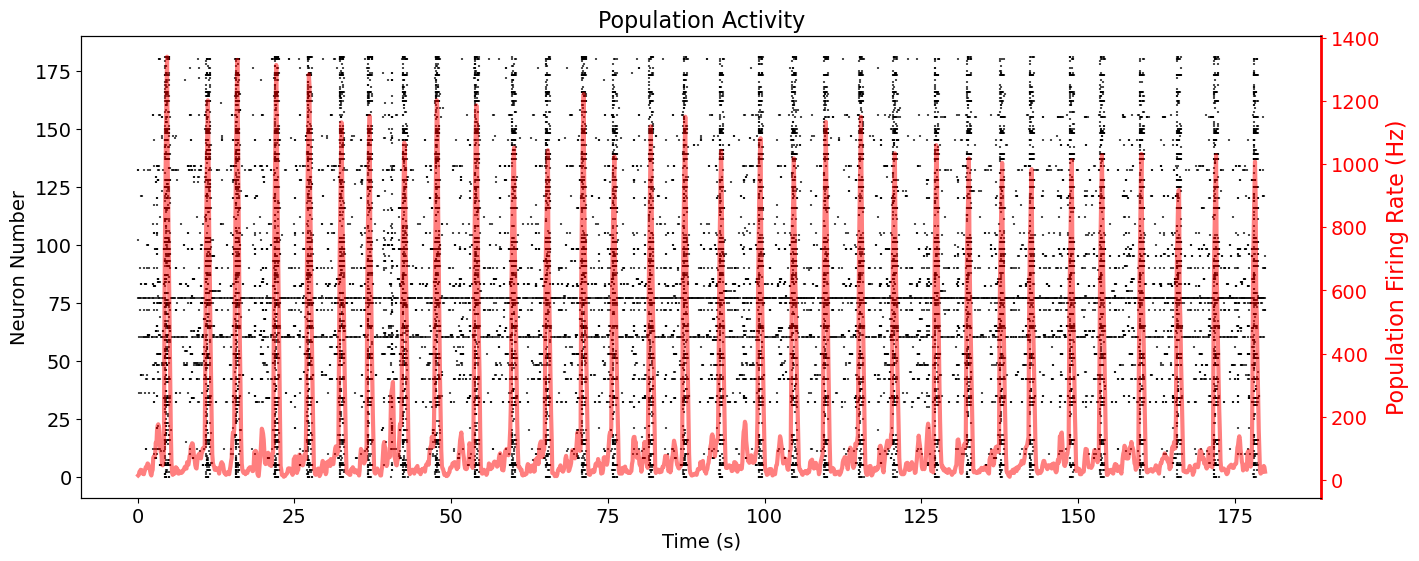

In [2]:
'''
Load in the curated EPhys Data as npz object 
  Data Structure:
    train: 
        Format: {neuron, [associated spike times]}
        Explanation: For each neuron, there is an associated list of spike times
    neuron_data: 
        Format: {neuron, [associated data]}
        Explanation: For each neuron, list of associated data (spatial coordinates, etc.)
    redundant_pairs: literally that
        Format: {neuron, [associated redundant pairs]}
        Explanation: For each neuron, list of associated redundant
    fs: sampling rate
        Format: int
        Explanation: Sampling rate of the data
'''
fname = "data.npz"
data = np.load(fname, allow_pickle=True)

# # Uncomment to see formatting
# print(data.files)
# print(f"trains's type is: {type(data['train'])}")
# print(f"neuron_data's type is: {type(data['neuron_data'])}")
# print(f"redundant_pairs's type is: {type(data['redundant_pairs'])}")
# print(f"fs's type is: {type(data['fs'])}")

# .item() to extract the dictionary from the npz object
neuron_data = data["neuron_data"].item()  # additional information (positional)
sample_freq = data['fs']                  # fs = frequency sample
spike_train = data['train'].item()        # train = spike times

normalized_train = [times/sample_freq for neuron_ID, times in spike_train.items()]
# We now have a list of neurons, each with associated spike times

def get_population_fr(trains: list, bin_size=0.1, w=5):
    ''' Bin population frequencies by time '''
    trains = np.hstack(trains)
    rec_length = np.max(trains)
    bin_num = int(rec_length// bin_size) + 1
    bins = np.linspace(0, rec_length, bin_num)
    fr = np.histogram(trains, bins)[0] / bin_size
    fr_avg = np.convolve(fr, np.ones(w), 'same') / w
    return bins[1:], fr_avg

# Plot Setup
fig, axs = plt.subplots(1, 1, figsize=(16, 6))
axs1 = axs.twinx()

# Plot population
bins, fr_avg = get_population_fr(trains=normalized_train)
axs1.plot(bins, fr_avg, color='r', linewidth=3, alpha=0.5)

# Plot individual neurons
y = 0
for train in normalized_train:
    axs.scatter(train, [y]*len(train), marker="|", c='k', s=4, alpha=0.7)
    y += 1

# Individual neuron plot
axs.set_title("Population Activity", fontsize=16)
axs.set_xlabel("Time (s)", fontsize=14)
axs.set_ylabel("Neuron Number", fontsize=14)
axs.xaxis.set_tick_params(labelsize=14)
axs.yaxis.set_tick_params(labelsize=14)

# Population plot
axs1.set_ylabel("Population Firing Rate (Hz)", fontsize=16, color='r')
axs1.set_xlabel("Time (s)", fontsize=14)
axs1.spines['right'].set_color('r')
axs1.spines['right'].set_linewidth(2)
axs1.tick_params(axis='y', colors='r')
axs1.yaxis.set_tick_params(labelsize=14)

### So, How do we quantify characteristics of the data?  *** WIP ***

Spike Timing:
	- ISI Distribution
Firing Rates:
		- Mean firing rates
		- Stochasticity quantification
Population Dynamics:
		* Raster plot
Oscillatory Dynamics:
		- Phase locking
		- Rayleigh test for assessing theta/gamma phase dist.

In [3]:
# < CODE HERE >

### Cool. Now that we have an idea of what the data is, and how we can analyze it, let's get started with the Spiking Neuron Model    

The first thing we need to do is convert the data into a format that can be used by the model. SNNs are trained with 
binary spike trains, so we need to convert the data into binary spikes.

In [48]:
def spike_train_to_binary(spike_train, spike_freq):

    '''
    Function to convert spike times to binary spikes in torch tensor

    Parameters:
        spike_train: dictionary of neuron ID and spike times {neuron, [associated spike times]}
        num_neurons: number of neurons (int)
        spike_freq: sampling rate (int)
    Output:
        binary_spikes: binary spike tensor (num_neurons x num_samples)
    '''

    # Constants
    num_neurons = len(spike_train)
    dt = 1 / spike_freq
    max_time = max([max(spike_train[neuron]) for neuron in spike_train]) / spike_freq
    time_bins = int(max_time / dt) + 1          # Bins of 1/spike_freq units  

    # print(f"num_neurons: {num_neurons}")
    # print(f"num_bins: {time_bins}")
    # print(f"dt: {dt}")

    # Create binary spike tensor
    binary_spikes = np.zeros((num_neurons, time_bins))
    for i, (neuron, spike_times) in enumerate(spike_train.items()):
        spike_bins = [int(time // dt) for time in spike_times]
        spike_bins = [min(bin_idx, time_bins - 1) for bin_idx in spike_bins]
        binary_spikes[i, spike_bins] = 1
    tensoredData = torch.Tensor(binary_spikes)

    return tensoredData

# Convert spike train to binary spikes
binary_spike_train_tensor = spike_train_to_binary(spike_train=spike_train, spike_freq=sample_freq)


# Print shape of binary spike tensor
print(binary_spike_train_tensor.shape)

torch.Size([182, 3595623])


### Reasoning Notes:
I chose to do Leaky -> FC -> Leaky so that the initial data could be transformed into a more useful format for the model. The FC layer is used to project onto higher dimensions, and the final Leaky layer is used to transform the data back into a binary format.

In [ ]:
# Lets start with a simple LIF model

# SELF NOTE: Can we quantify the performance of using SNN vs normal NN for temporal data?
# SELF NOTE: Can we add spatial components to the SNN model?

class SimpleLeakySNN(nn.Module):
    '''
    Simple Leaky Integrate-and-Fire (LIF) SNN Model
    Input dimensionality: [time, batch_size, input_neurons]
    '''
    def __init__(self, 
                 num_input_neurons, 
                 num_hidden_neurons, 
                 num_output_neurons, 
                 num_steps, 
                 beta_hidden=0.9, 
                 beta_output=0.9):
        super(SimpleLeakySNN, self).__init__()

        self.num_hidden_neurons = num_hidden_neurons
        self.num_output_neurons = num_output_neurons
        self.num_steps = num_steps

        # Define layers
        self.fully_connected_1 = nn.Linear(num_input_neurons, num_hidden_neurons)
        self.lif_hidden_layer1 = snn.Leaky(beta=beta_hidden)

        self.fully_connected_2 = nn.Linear(num_hidden_neurons, num_output_neurons)
        self.lif_output_layer = snn.Leaky(beta=beta_output)

    def forward(self, input):
        batch_size = input.size(1)

        # Initialize membrane potentials
        mem_hidden = self.lif_hidden_layer1.init_leaky()
        mem_output = self.lif_output_layer.init_leaky()

        # Output spikes across time
        output_spikes = torch.zeros(self.num_steps, batch_size, self.num_output_neurons)

        # Forward pass
        for step in range(self.num_steps):

            # Hidden layer
            current_hidden = self.fully_connected_1(input[step])
            spike_hidden, mem_hidden = self.lif_hidden_layer1(current_hidden, mem_hidden)

            # Output layer
            current_output = self.fully_connected_2(spike_hidden)
            spike_output, mem_output = self.lif_output_layer(current_output, mem_output)

            output_spikes[step] = spike_output  # Store spikes

        return output_spikes

# Parameters
num_input_neurons = 180
num_hidden_neurons = 300
num_output_neurons = 180
num_steps = 100
batch_size = 10

# Instantiate the model
model = SimpleLeakySNN(num_input_neurons, num_hidden_neurons, num_output_neurons, num_steps)

# Generate fake input data [time, batch_size, input_neurons]
input_spikes = torch.randn(num_steps, batch_size, num_input_neurons)

# Forward pass
output_spikes = model(input_spikes)

print("Input shape:", input_spikes.shape)  # Expected: [100, 10, 180]
print("Output shape:", output_spikes.shape)  # Expected: [100, 10, 180]

Input shape: torch.Size([100, 10, 180])
Output shape: torch.Size([100, 10, 180])


torch.Size([180, 300])
